# Projeto 2 - Classificador Automático de Sentimento

Você foi contratado por uma empresa parar analisar como os clientes estão reagindo a um determinado produto no Twitter. A empresa deseja que você crie um programa que irá analisar as mensagens disponíveis e classificará como "relevante" ou "irrelevante". Com isso ela deseja que mensagens negativas, que denigrem o nome do produto, ou que mereçam destaque, disparem um foco de atenção da área de marketing.<br /><br />
Como aluno de Ciência dos Dados, você lembrou do Teorema de Bayes, mais especificamente do Classificador Naive-Bayes, que é largamente utilizado em filtros anti-spam de e-mails. O classificador permite calcular qual a probabilidade de uma mensagem ser relevante dadas as palavras em seu conteúdo.<br /><br />
Para realizar o MVP (*minimum viable product*) do projeto, você precisa implementar uma versão do classificador que "aprende" o que é relevante com uma base de treinamento e compara a performance dos resultados com uma base de testes.<br /><br />
Após validado, o seu protótipo poderá também capturar e classificar automaticamente as mensagens da plataforma.

## Informações do Projeto

Prazo: 13/Set até às 23:59.<br />
Grupo: 1 ou 2 pessoas.<br /><br />
Entregáveis via GitHub: 
* Arquivo notebook com o código do classificador, seguindo as orientações abaixo.
* Arquivo Excel com as bases de treinamento e teste totalmente classificado.

**NÃO disponibilizar o arquivo com os *access keys/tokens* do Twitter.**


### Check 3: 

Até o dia 06 de Setembro às 23:59, o notebook e o xlsx devem estar no Github com as seguintes evidências: 
    * Conta no twitter criada.
    * Produto escolhido.
    * Arquivo Excel contendo a base de treinamento e teste já classificado.

Sugestão de leitura:<br />
http://docs.tweepy.org/en/v3.5.0/index.html<br />
https://monkeylearn.com/blog/practical-explanation-naive-bayes-classifier/

___

## Preparando o ambiente

Instalando a biblioteca *tweepy* para realizar a conexão com o Twitter:

In [1]:
%%capture

#Instalando o tweepy
!pip install tweepy

Importando as Bibliotecas que serão utilizadas. Esteja livre para adicionar outras.

In [2]:
import tweepy
import math
import os.path
import pandas as pd
import json
from random import shuffle

___
## Autenticando no  Twitter

Para realizar a captura dos dados é necessário ter uma conta cadastrada no twitter:

* Conta: @MarcoMolipp


1. Caso ainda não tenha uma: https://twitter.com/signup
1. Depois é necessário registrar um app para usar a biblioteca: https://apps.twitter.com/
1. Dentro do registro do App, na aba Keys and Access Tokens, anotar os seguintes campos:
    1. Consumer Key (API Key)
    1. Consumer Secret (API Secret)
1. Mais abaixo, gere um Token e anote também:
    1. Access Token
    1. Access Token Secret
    
1. Preencha os valores no arquivo "auth.pass"

**ATENÇÃO**: Nunca divulgue os dados desse arquivo online (GitHub, etc). Ele contém as chaves necessárias para realizar as operações no twitter de forma automática e portanto é equivalente a ser "hackeado". De posse desses dados, pessoas mal intencionadas podem fazer todas as operações manuais (tweetar, seguir, bloquear/desbloquear, listar os seguidores, etc). Para efeito do projeto, esse arquivo não precisa ser entregue!!!

In [3]:
#Dados de autenticação do twitter:


#Coloque aqui o identificador da conta no twitter: @MarcoMolipp

#leitura do arquivo no formato JSON
with open('auth.pass') as fp:    
    data = json.load(fp)

#Configurando a biblioteca. Não modificar
auth = tweepy.OAuthHandler(data['consumer_key'], data['consumer_secret'])
auth.set_access_token(data['access_token'], data['access_token_secret'])

___
## Coletando Dados

Agora vamos coletar os dados. Tenha em mente que dependendo do produto escolhido, não haverá uma quantidade significativa de mensagens, ou ainda poder haver muitos retweets.<br /><br /> 
Configurando:

In [7]:
#Produto escolhido:
produto = 'Fire Emblem'

#Quantidade mínima de mensagens capturadas:
n = 500
#Quantidade mínima de mensagens para a base de treinamento:
t = 300

#Filtro de língua, escolha uma na tabela ISO 639-1.
lang = 'pt'

Capturando os dados do twitter:

In [8]:
#Cria um objeto para a captura
api = tweepy.API(auth)

#Inicia a captura, para mais detalhes: ver a documentação do tweepy
i = 1
msgs = []
for msg in tweepy.Cursor(api.search, q=produto, lang=lang).items():    
    msgs.append(msg.text.lower())
    i += 1
    if i > n:
        break

#Embaralhando as mensagens para reduzir um possível viés
shuffle(msgs)

Salvando os dados em uma planilha Excel:

In [9]:
#Verifica se o arquivo não existe para não substituir um conjunto pronto
if not os.path.isfile('./{0}.xlsx'.format(produto)):
    
    #Abre o arquivo para escrita
    writer = pd.ExcelWriter('{0}.xlsx'.format(produto))

    #divide o conjunto de mensagens em duas planilhas
    dft = pd.DataFrame({'Treinamento' : pd.Series(msgs[:t])})
    dft.to_excel(excel_writer = writer, sheet_name = 'Treinamento', index = False)

    dfc = pd.DataFrame({'Teste' : pd.Series(msgs[t:])})
    dfc.to_excel(excel_writer = writer, sheet_name = 'Teste', index = False)

    #fecha o arquivo
    writer.save()

___
## Classificando as Mensagens

Agora você deve abrir o arquivo Excel com as mensagens capturadas e classificar na Coluna B se a mensagem é relevante ou não.<br /> 
Não se esqueça de colocar um nome para a coluna na célula **B1**.<br /><br />
Fazer o mesmo na planilha de Controle.

___
## Montando o Classificador Naive-Bayes

Com a base de treinamento montada, comece a desenvolver o classificador. Escreva o seu código abaixo:

Opcionalmente: 
* Limpar as mensagens removendo os caracteres: enter, :, ", ', (, ), etc. Não remover emojis.<br />
* Corrigir separação de espaços entre palavras e/ou emojis.
* Propor outras limpezas/transformações que não afetem a qualidade da informação.



In [2]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

dados = pd.read_excel('Fire Emblem.xlsx',sep=',')


In [20]:
df = pd.read_excel('Fire Emblem.xlsx',sep=',')

pont = [":",",",".",";",'"',"'","(",")"]
palavrasruins = ["e","a","o","ou","de","da","dos","das"]


palavras = {}
for i in range(len(df['Treinamento'])):
    df['Treinamento'][i] = df['Treinamento'][i].lower()
    df['Treinamento'][i]=df['Treinamento'][i].split( )
    
    for x in range(len(df['Treinamento'][i])):
        if x >= len(df['Treinamento'][i]):
            break
        while df['Treinamento'][i][x][-1] in pont:
            df['Treinamento'][i][x] = df['Treinamento'][i][x][0:-1]
            if df['Treinamento'][i][x] == "":
                break
        if df['Treinamento'][i][x] == "":
            del df['Treinamento'][i][x]
        elif df['Treinamento'][i][x] in palavrasruins:
            del df['Treinamento'][i][x]
        elif df['Treinamento'][i][x][0] == "@":
            del df['Treinamento'][i][x]
        else:
            if df['Treinamento'][i][x] not in palavras:
                palavras[df['Treinamento'][i][x]] = {"Relevante":0,"Irrelevante":0}
            palavras[df['Treinamento'][i][x]][df['Relevância'][i]] +=1
palavras

{'!': {'Irrelevante': 52, 'Relevante': 0},
 '"[hd][fr]fire': {'Irrelevante': 1, 'Relevante': 0},
 '"fire': {'Irrelevante': 1, 'Relevante': 0},
 '"lord': {'Irrelevante': 1, 'Relevante': 0},
 '"morada': {'Irrelevante': 0, 'Relevante': 1},
 '"pupilo': {'Irrelevante': 1, 'Relevante': 0},
 '##ebay': {'Irrelevante': 1, 'Relevante': 0},
 '#39': {'Irrelevante': 1, 'Relevante': 0},
 '#40': {'Irrelevante': 1, 'Relevante': 0},
 '#7': {'Irrelevante': 1, 'Relevante': 0},
 '#82': {'Irrelevante': 0, 'Relevante': 1},
 '#anime': {'Irrelevante': 1, 'Relevante': 0},
 '#fe_escaramouche': {'Irrelevante': 1, 'Relevante': 0},
 '#fe_escarmouche': {'Irrelevante': 53, 'Relevante': 0},
 '#feh': {'Irrelevante': 1, 'Relevante': 0},
 '#feheroeds': {'Irrelevante': 1, 'Relevante': 0},
 '#feheroegs': {'Irrelevante': 1, 'Relevante': 0},
 '#feheroes': {'Irrelevante': 53, 'Relevante': 0},
 '#feheroesg': {'Irrelevante': 1, 'Relevante': 0},
 '#fireemblem': {'Irrelevante': 3, 'Relevante': 0},
 '#fireemblemechoes…': {'Irrele

In [24]:
relevantes=0
irrelevantes=0

for a in palavras.keys():
    if palavras[a]["Relevante"] != 0:
        relevantes +=1
    if palavras[a]["Irrelevante"] != 0:
        irrelevantes +=1
print(relevantes)
print(irrelevantes)

339
676


In [102]:
def classificar(frazes):
    rel = 1
    irrel = 1
    classific = []
    for i in range(len(frazes)):
        frazes[i] = frazes[i].lower()
        frazes[i]=frazes[i].split( )
    
        for x in range(len(frazes[i])):
            if x >= len(frazes[i]):
                break
            while frazes[i][x][-1] in pont:
                frazes[i][x] = frazes[i][x][0:-1]
                if frazes[i][x] == "":
                    break
            if frazes[i][x] == "":
                del frazes[i][x]
            elif frazes[i][x] in palavrasruins:
                del frazes[i][x]
            elif frazes[i][x][0] == "@":
                del frazes[i][x]
            elif frazes[i][x] in palavras:
                rel *= palavras[frazes[i][x]]['Relevante']+1
                irrel *= palavras[frazes[i][x]]['Irrelevante']+1
                
        relevant = rel/(relevantes*len(palavras.keys()))
        irrelev = irrel/(irrelevantes*len(palavras.keys()))
        if relevant > irrelev:
            if relevant - irrelev > 100:
                classific.append("Muito Relevante")
            else:
                classific.append("Relevante")
        elif relevant < irrelev:
            if irrelev - relevant  > 100:
                classific.append("Muito Irrelevante")
            else:
                classific.append("Irrelevante")
        else:
            classific.append("Desconhecido")
        rel = 1
        irrel = 1
    return classific

___
## Verificando a performance

Agora você deve testar o seu Classificador com a base de Testes.<br /><br /> 

Você deve extrair as seguintes medidas:
* Porcentagem de positivos falsos (marcados como relevante mas não são relevantes)
* Porcentagem de positivos verdadeiros (marcado como relevante e são relevantes)
* Porcentagem de negativos verdadeiros (marcado como não relevante e não são relevantes)
* Porcentagem de negativos falsos (marcado como não relevante e são relevantes)

Opcionalmente:
* Criar categorias intermediárias de relevância baseado na diferença de probabilidades. Exemplo: muito relevante, relevante, neutro, irrelevante e muito irrelevante.

In [103]:
tst = pd.read_excel('Fire Emblem.xlsx',sep=',',sheetname='Teste')
teste = classificar(tst['Teste'])
teste

['Muito Irrelevante',
 'Muito Irrelevante',
 'Irrelevante',
 'Irrelevante',
 'Muito Irrelevante',
 'Irrelevante',
 'Irrelevante',
 'Irrelevante',
 'Irrelevante',
 'Muito Irrelevante',
 'Muito Relevante',
 'Muito Irrelevante',
 'Irrelevante',
 'Irrelevante',
 'Irrelevante',
 'Muito Irrelevante',
 'Irrelevante',
 'Irrelevante',
 'Irrelevante',
 'Irrelevante',
 'Irrelevante',
 'Muito Irrelevante',
 'Relevante',
 'Muito Irrelevante',
 'Muito Irrelevante',
 'Irrelevante',
 'Irrelevante',
 'Irrelevante',
 'Irrelevante',
 'Irrelevante',
 'Irrelevante',
 'Irrelevante',
 'Relevante',
 'Relevante',
 'Muito Irrelevante',
 'Muito Irrelevante',
 'Muito Relevante',
 'Irrelevante',
 'Irrelevante',
 'Relevante',
 'Irrelevante',
 'Irrelevante',
 'Irrelevante',
 'Muito Relevante',
 'Irrelevante',
 'Irrelevante',
 'Muito Irrelevante',
 'Irrelevante',
 'Muito Irrelevante',
 'Irrelevante',
 'Irrelevante',
 'Relevante',
 'Irrelevante',
 'Irrelevante',
 'Irrelevante',
 'Muito Irrelevante',
 'Irrelevante',
 '

In [104]:
re =[]
ir =[]
totrel =0
totirr =0
for a in range(len(tst['Teste'])):
    if tst["Relevância"][a] == "Relevante":
        re.append(a)
        totrel+=1
    elif tst["Relevância"][a] == "Irrelevante":
        ir.append(a)
        totirr+=1


listrel=[]
listirr=[]
for b in re:
    listrel.append(teste[b])
for c in ir:
    listirr.append(teste[c])

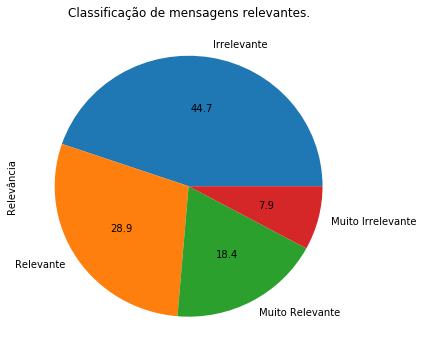

In [105]:
df1 = pd.DataFrame.from_dict({'Relevância':listrel})
df1 = df1['Relevância']
df1 = (df1.value_counts(normalize=True)*100).round(decimals=1)#.reindex(['SIM','NÃO'])
# Gráfico de Setor
plot = df1.plot(kind='pie',title='Classificação de mensagens relevantes.',autopct='%.1f',figsize=(6, 6))

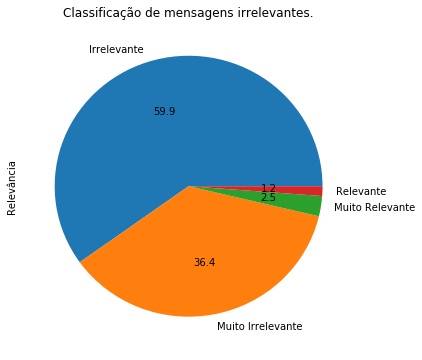

In [106]:
df2 = pd.DataFrame.from_dict({'Relevância':listirr})
df2 = df2['Relevância']
df2 = (df2.value_counts(normalize=True)*100).round(decimals=1)#.reindex(['SIM','NÃO'])
# Gráfico de Setor
plot = df2.plot(kind='pie',title='Classificação de mensagens irrelevantes.',autopct='%.1f',figsize=(6, 6))

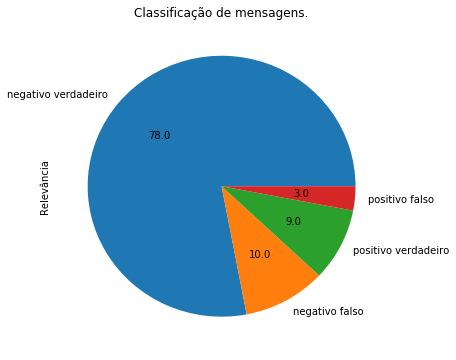

In [107]:
listall=[]
for e in range(len(listrel)):
    if listrel[e]=="Relevante" or listrel[e]=="Muito Relevante":
        listall.append('positivo verdadeiro')
    elif listrel[e]=="Irrelevante" or listrel[e]=="Muito Irrelevante":
        listall.append('negativo falso')
for f in range(len(listirr)):
    if listirr[f]=="Relevante" or listirr[f]=="Muito Relevante":
        listall.append('positivo falso')
    elif listirr[f]=="Irrelevante" or listirr[f]=='Muito Irrelevante':
        listall.append('negativo verdadeiro')
        
df3 = pd.DataFrame.from_dict({'Relevância':listall})
df3 = df3['Relevância']
df3 = (df3.value_counts(normalize=True)*100).round(decimals=1)#.reindex(['SIM','NÃO'])
# Gráfico de Setor
plot = df3.plot(kind='pie',title='Classificação de mensagens.',autopct='%.1f',figsize=(6, 6))

___
## Concluindo

Escreva aqui a sua conclusão.<br /> 
Faça um comparativo qualitativo sobre as medidas obtidas.<br />
Explique como são tratadas as mensagens com dupla negação e sarcasmo.<br />
Proponha um plano de expansão. Por que eles devem continuar financiando o seu projeto?<br />

Opcionalmente: 
* Discorrer por que não posso alimentar minha base de Treinamento automaticamente usando o próprio classificador, aplicado a novos tweets.
* Propor diferentes cenários de uso para o classificador Naive-Bayes. Cenários sem intersecção com este projeto.
* Sugerir e explicar melhorias reais no classificador com indicações concretas de como implementar (não é preciso codificar, mas indicar como fazer e material de pesquisa sobre o assunto).


Podemos concluir com relação ao estudo realisado que o programa classificou as mensagens considerads irrelevantes com muito mais precisão do que as mensagens consideradas relevantes. Dessa forma, qualitativamente, não consideramos um bom resultado, pois, a imprecisão nas mensagens relevantes, que por si só são mais importantes, foi muito alta.
É possível que essa imprecição seja causada pela dificulda de do programa em interpretar o significado das mensagens já que ele apenas lê as palavras separadamente. Mensagens ambíguas, com duplo sentido ou sarcásticas são análisadas como se fossem literais, por exemplo.
Outra possível causa seria o pequeno espaço amostral das mensagens relevantes usadas para classificar as palavras em comparação com o das irrelevantes. Uma das maneiras de expandir e melhorar o projeto seria aumentar essa amostra para melhorar a precisão.
Outra maneira de melhorar o projeto seria filtrar melhor as palavras usadas, excluindo palavras como links e nomes de usuários, que dificilmente aparecerão repetidas vezes e indicarão a relevância.